<a href="https://colab.research.google.com/github/vanle2000/Titanic/blob/main/Titanic_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns 
%pylab inline 
import re 
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


# 1. Data preprocessing

## 1.1. Importing Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
titanic_df = pd.concat([train, test], axis=0)

## 1.2. Handing Missing Values:

In [3]:
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Dropping the `Cabin` column, since there is 687 missing values.

In [5]:
titanic_df.drop('Cabin', axis=1, inplace=True)
titanic_df.drop('PassengerId', axis=1, inplace=True)

Next, using `Imputation` technique to treat `Age`, `Embarked` and `Fare` columns with the purpose to fill in missing values with estimated values based on available data. There are mulitple methods for imputing missing data, including:


*   Mean or median imputation: involves filling in missing values with `mean` or `median` value of the variable.
*   Mode imputation: involves filling in missing values with the most common value (`mode`) of the variable.
*   Regression imputation: involves predicting the missing values using `regression` based on the other variables of the dataset. 
*   K-nearest neighbor imputation: involves finding the `k-nearest neighbors` to the observation with missing values and filling in the missing values with the average of those neighbors.
*   Multiple imputation: involves generating multiple imputed datasets by creating pausible values for the missing values based on `statistical models`, and using these datasets to estimate parameters and make predictions. 


Imputing the `Age` column with the `median` value

In [6]:
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)

Imputing the `Embrarked` column with the mode value

In [7]:
titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)

In [8]:
titanic_df['Fare'].fillna(titanic_df['Fare'].mode()[0], inplace=True)

Checking for missing values to confirm all missing values in training set have been handled.

In [9]:
titanic_df.isnull().sum()

Survived    418
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      0
dtype: int64

## 1.3. Encoding Categorical Variables
There are various method to encode the categorical variables, in this Titanic dataset, we will work with `one-hot encoding`.


In [10]:
cat_vars = ['Sex', 'Embarked']

# Perform one-hot encoding
encoder = ce.OneHotEncoder(cols=cat_vars,
                           handle_unknown='return_nan',
                           return_df=True,
                           use_cat_names=True)

titanic_df = encoder.fit_transform(titanic_df)

## 1.4. Feature Engineering

### Title Extraction:

In [37]:
def extract_title(Name):
  try:
    title_pattern = r", \s*([^\.]*)\."
    return re.search(title_pattern, str(Name)).group(1)
  except:
    return "Unknown"

titanic_df['Title'] = titanic_df['Name'].apply(extract_title)


def title_group(df):
    df['Title'] = df['Title'].replace(['Jonkheer', 'Don', 'Sir', 'Capt', 'Col', 'Major', 'Rev', 'Dr'], 'Mr')
    df['Title'] = df['Title'].replace(['Mme', 'the Countess'], 'Mrs')
    df['Title'] = df['Title'].replace(['Lady', 'Ms', 'Mlle'], 'Miss')
    df['Title'] = df['Title'].apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs'] else 'Other')
    
    return df

titanic_df = title_group(titanic_df)

In [38]:
# Group by title and get the count
titanic_df['Title'].value_counts()

Mr       783
Miss     265
Mrs      199
Other     62
Name: Title, dtype: int64

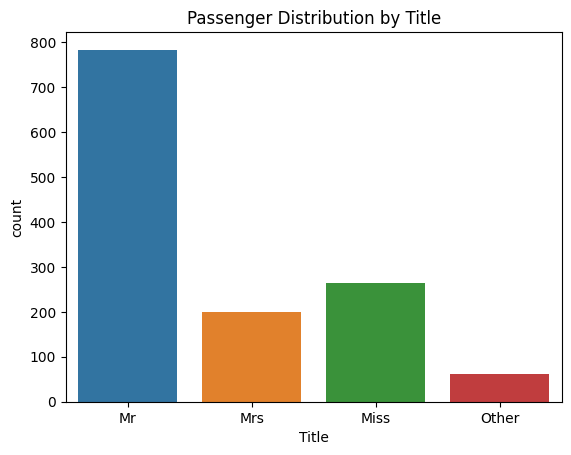

In [39]:
# Bar plot to visualize the distribution of passengers by title
sns.countplot(x='Title', data=titanic_df)
plt.title('Passenger Distribution by Title')
plt.show()